# Neural language models for text generation

<b>Objective</b><br>
The ability to generate text that resembles the quality of human language has numerous applications, from machine translation to spelling correction, from text summarization to image captioning. At the heart of these larger tasks is the language model, which is a function or algorithm for learning that function that captures relevant statistical characteristics of the distribution of sequences of words in a natural language (Bengio, 2008). This study is an examination of the neural language model, specifically, as a foundation for larger NLP tasks and a representative step in the evolution beyond traditional statistical modeling. Its goal is two-fold: develop neural language models for capturing the “essence” of a large corpora of text and gain an in-depth understanding of how various factors affect fitting and ultimate performance with networks with differing deep learning architectures. This will shed light on how hidden nodes learn to extract features from inputs; with additional layers, the objective is to better understand how each successive layer extracts progressively abstract and generalized features. This is done through the development, evaluation, and comparison of word-based neural language models for text generation.<br>

<b>Data source for model development and evaluation</b><br>
Data for this study comes from __[Project Gutenberg](https://www.gutenberg.org)__, a repository of over 60,000 publicly-available books, with focus on older works for which U.S. copyright has expired. Beyond a source of great literature free and open to everyone, the text versions of these works offer countless opportunities for experimentation with machine learning techniques using unstructured text. Each group of experiments in the study focuses on a particular novel, in this case <i>Alice's Adventures in Wonderland</i>, an 1865 novel written by English author Lewis Carroll. A separate study is conducted using Franz Kafka's 1915 novel <i>The Metamorphosis</i>, serving as a point of comparison.<br>

<b>Model development</b><br>
Using these two separate texts, various network architectures are tested to determine their ability to capture meaning and context from these two texts and generate reliable, believable sequences of related text based on predictions of probability given an input sequence of text. Long Short-Term Memory (LSTM) Recurrent Neural Networks (RNNs) are employed primarily given these networks’ established performance with text generation and ability to help mitigate, in some cases, overfitting and the challenge of vanishing gradients. LSTM RNNs are also the focus due to their potential to retain sequence-based meaning, from words in sentences to sentences in paragraphs; the longer nature of these texts offers a useful data source for testing this possibility. Varying network depth and width are investigated for potential impact on performance, which is ultimately measured quantitatively (via loss and training time) and qualitatively (via generated text examples from seed text and comparison to actual text that follows). While this evaluation is not perfectly objective, these combined steps shed light on how well the various models capture meaning from text, which serves as useful in certain standalone cases and, more importantly, as a critical input to more complex NLP tasks.

<b>Model evaluation</b><br>
Model accuracy, loss, and training time are all measured for evaluation purposes. It is important to mention that the most accurate classification model of the training dataset is not the objective - this would reflect rote memorization of the text, which would reveal nothing meaningful about the neural networks' ability to capture the essence of the text. What is more important is a generalization of the dataset and the minimization of the chosen loss function, categorical cross-entropy. The ultimate goal is a balance between generalization and overfitting, which is difficult to measure. Qualitative evaluation and exploration of multiple examples will serve as proxy metrics for performance. 

## 1. Environment preparation

In [1]:
# Import dependencies
import string
import re
import os
import time
import numpy as np
from numpy import array
import pandas as pd
from collections import Counter
from random import randint
from pickle import load, dump

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
# Mount point for Colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Save in Colab
os.getcwd()
%cd /content/gdrive/My\ Drive/MSDS458/A4/alice
!pwd
# !ls
print('Working Directory')
print(os.getcwd())
work_dir = "content/gdrive/My Drive/MSDS458/A4/alice"

/content/gdrive/My Drive/MSDS458/A4/alice
/content/gdrive/My Drive/MSDS458/A4/alice
Working Directory
/content/gdrive/My Drive/MSDS458/A4/alice


In [0]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## 2. Data load, pre-processing, and exploration
Pre-processing steps involve the following:
* Loading the text document
* Cleaning the document (lower-casing, removal of punctuation, tokenization)
* Saving a clean copy of the text

Exploratory data analysis is conducted as well:
* Outputting most- and least-frequent tokens (with and without stopwords removed) to explore word frequencies 
* Bigram counts to explore which two-word pairs of words occur frequently. This can help reveal (potentially) more meaningful frequencies than single words simply as they appear on their own in the text.
* Defining a function for lexical diversity and calculating it for the text as is, and also with stopwords removed. Lexical diversity refers to the range of different words used in a text. Its meaning is text-dependent and not a perfect reflection, however it gives an indication of the scope of different kinds of words in the text; a greater range (higher number) may indicate higher diversity. It is the number of unique tokens in a text as a proportion of total tokens, calculated as follows:

$$
\frac{len(set(text)}{len(text)}
$$

In [0]:
# Define function to load document into memory
def load_doc(filename):
    # Open the file as read only
    file = open(filename, 'r')
    # Read all text
    text = file.read()
    # Close the file
    file.close()
    return text

In [6]:
# Load document
in_filename = 'input/alice-clean.txt'
doc = load_doc(in_filename)
print(doc[:400])

CHAPTER I


[Sidenote: _Down the Rabbit-Hole_]

ALICE was beginning to get very tired of sitting by her
sister on the bank, and of having nothing to do: once or twice she had
peeped into the book her sister was reading, but it had no pictures or
conversations in it, "and what is the use of a book," thought Alice,
"without pictures or conversations?"

So she was considering in her own mind (as well


### 1. Clean text

In [0]:
# Define function for turning document into clean tokens
def clean_doc(doc):
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens

In [8]:
# Clean document and output total and unique values
tokens = clean_doc(doc)
vocab = set(tokens)
print(tokens[:200])
print('---------------------------------------')
print('Total tokens: %d' % len(tokens))
print('--------------------------')
print('Unique tokens: %d' % len(set(tokens)))

['chapter', 'i', 'sidenote', 'down', 'the', 'rabbithole', 'alice', 'was', 'beginning', 'to', 'get', 'very', 'tired', 'of', 'sitting', 'by', 'her', 'sister', 'on', 'the', 'bank', 'and', 'of', 'having', 'nothing', 'to', 'do', 'once', 'or', 'twice', 'she', 'had', 'peeped', 'into', 'the', 'book', 'her', 'sister', 'was', 'reading', 'but', 'it', 'had', 'no', 'pictures', 'or', 'conversations', 'in', 'it', 'and', 'what', 'is', 'the', 'use', 'of', 'a', 'book', 'thought', 'alice', 'without', 'pictures', 'or', 'conversations', 'so', 'she', 'was', 'considering', 'in', 'her', 'own', 'mind', 'as', 'well', 'as', 'she', 'could', 'for', 'the', 'hot', 'day', 'made', 'her', 'feel', 'very', 'sleepy', 'and', 'stupid', 'whether', 'the', 'pleasure', 'of', 'making', 'a', 'daisychain', 'would', 'be', 'worth', 'the', 'trouble', 'of', 'getting', 'up', 'and', 'picking', 'the', 'daisies', 'when', 'suddenly', 'a', 'white', 'rabbit', 'with', 'pink', 'eyes', 'ran', 'close', 'by', 'her', 'there', 'was', 'nothing', 'so

### 2. Exploratory data analysis

In [0]:
# Define functions for lexical diversity and percentage of total
def lexical_diversity(text):
    return len(set(text)) / len(text) 

def percentage(count, total):   
    return 100 * count / total

In [10]:
lexical_diversity(tokens)

0.09900063629898566

In [0]:
# Plot word frequency
# Initialize a dictionary
dict = {}

# Count number of times each word comes up in list of words
for key in tokens: 
    dict[key] = dict.get(key, 0) + 1

counts = sorted(dict.items(), key = lambda x: x[1], reverse = True)

In [0]:
# Most and least frequent word occurence
top_counts = counts[:30]
least_counts = counts[-30:]

In [13]:
print('top_counts:', top_counts)
print('--------------------------')
print('least_counts:', least_counts)

top_counts: [('the', 1645), ('and', 870), ('to', 729), ('a', 632), ('she', 543), ('it', 533), ('of', 509), ('said', 465), ('i', 408), ('alice', 386), ('in', 366), ('you', 366), ('was', 358), ('that', 284), ('as', 261), ('her', 250), ('at', 210), ('on', 192), ('with', 186), ('all', 184), ('had', 179), ('but', 172), ('so', 154), ('for', 150), ('be', 150), ('not', 146), ('very', 144), ('what', 140), ('this', 137), ('they', 131)]
--------------------------
least_counts: [('lizards', 1), ('slatepencil', 1), ('choking', 1), ('believed', 1), ('reality', 1), ('rustling', 1), ('rippling', 1), ('reeds', 1), ('tinkling', 1), ('sheepbells', 1), ('cries', 1), ('shepherd', 1), ('noises', 1), ('clamour', 1), ('farmyard', 1), ('lowing', 1), ('cattle', 1), ('lastly', 1), ('pictured', 1), ('aftertime', 1), ('riper', 1), ('years', 1), ('loving', 1), ('childhood', 1), ('gather', 1), ('sorrows', 1), ('joys', 1), ('remembering', 1), ('childlife', 1), ('happy', 1)]


**Figure 1: 30 most frequently occurring tokens in text**

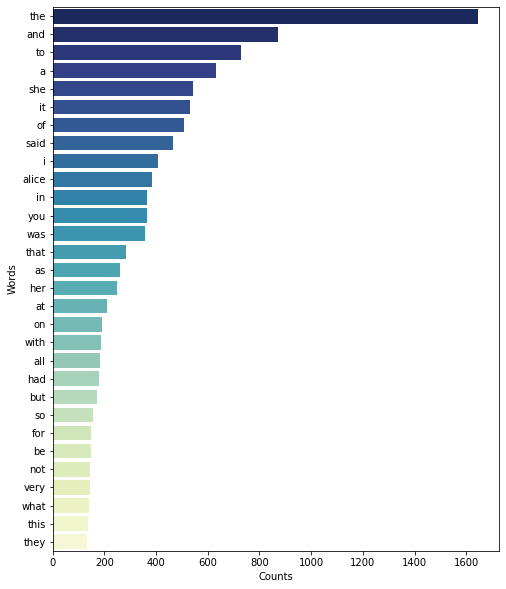

In [14]:
# Plot frequencies
words_plot = pd.DataFrame(top_counts, columns = ['Words', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Words", x="Counts", data=words_plot, palette = "YlGnBu_r")

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# Function to create clean doc with stopwords removed
def clean_doc_sw(doc):
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    # remove stopwords
    stop_words = set(stopwords.words('english')) 
    # stop_words = nltk.corpus.stopwords.words('english')
    newStopWords = ['i','the','he','on','shall']
    stop_words.update(newStopWords)
    tokens = [w for w in tokens if not w in stop_words]
    return tokens

In [17]:
# clean document
tokens_sw = clean_doc_sw(doc)
print(tokens_sw[:200])
print('Total tokens: %d' % len(tokens_sw))
print('--------------------------')
print('Unique tokens: %d' % len(set(tokens_sw)))

['chapter', 'sidenote', 'rabbithole', 'alice', 'beginning', 'get', 'tired', 'sitting', 'sister', 'bank', 'nothing', 'twice', 'peeped', 'book', 'sister', 'reading', 'pictures', 'conversations', 'use', 'book', 'thought', 'alice', 'without', 'pictures', 'conversations', 'considering', 'mind', 'well', 'could', 'hot', 'day', 'made', 'feel', 'sleepy', 'stupid', 'whether', 'pleasure', 'making', 'daisychain', 'would', 'worth', 'trouble', 'getting', 'picking', 'daisies', 'suddenly', 'white', 'rabbit', 'pink', 'eyes', 'ran', 'close', 'nothing', 'remarkable', 'alice', 'think', 'much', 'way', 'hear', 'rabbit', 'say', 'oh', 'dear', 'oh', 'dear', 'late', 'thought', 'afterwards', 'occurred', 'ought', 'wondered', 'time', 'seemed', 'quite', 'natural', 'rabbit', 'actually', 'took', 'watch', 'waistcoatpocket', 'looked', 'hurried', 'alice', 'started', 'feet', 'flashed', 'across', 'mind', 'never', 'seen', 'rabbit', 'either', 'waistcoatpocket', 'watch', 'take', 'burning', 'curiosity', 'ran', 'across', 'fiel

In [18]:
lexical_diversity(tokens_sw)

0.19784455632473252

In [0]:
# Plot word frequency
# Initialize a dictionary
dict_sw = {}

# Count number of times each word comes up in list of words
for key in tokens_sw: 
    dict_sw[key] = dict_sw.get(key, 0) + 1

counts_sw = sorted(dict_sw.items(), key = lambda x: x[1], reverse = True)

In [0]:
# Most and least frequent word occurence
top_counts_sw = counts_sw[:30]
least_counts_sw = counts_sw[-30:]

In [21]:
print('top_counts with stopwords removed:', top_counts_sw)
print('--------------------------')
print('least_counts with stopwords removed:', least_counts_sw)

top_counts with stopwords removed: [('said', 465), ('alice', 386), ('little', 129), ('one', 104), ('know', 87), ('would', 85), ('like', 85), ('went', 81), ('could', 78), ('thought', 73), ('queen', 71), ('time', 68), ('see', 67), ('dont', 61), ('king', 61), ('well', 60), ('im', 59), ('began', 58), ('turtle', 58), ('mock', 57), ('quite', 55), ('hatter', 55), ('gryphon', 55), ('way', 54), ('think', 52), ('much', 51), ('first', 51), ('head', 51), ('go', 51), ('say', 50)]
--------------------------
least_counts with stopwords removed: [('lizards', 1), ('slatepencil', 1), ('choking', 1), ('believed', 1), ('reality', 1), ('rustling', 1), ('rippling', 1), ('reeds', 1), ('tinkling', 1), ('sheepbells', 1), ('cries', 1), ('shepherd', 1), ('noises', 1), ('clamour', 1), ('farmyard', 1), ('lowing', 1), ('cattle', 1), ('lastly', 1), ('pictured', 1), ('aftertime', 1), ('riper', 1), ('years', 1), ('loving', 1), ('childhood', 1), ('gather', 1), ('sorrows', 1), ('joys', 1), ('remembering', 1), ('childlif

**Figure 2: 30 most frequently occurring tokens in text, stopwords removed**

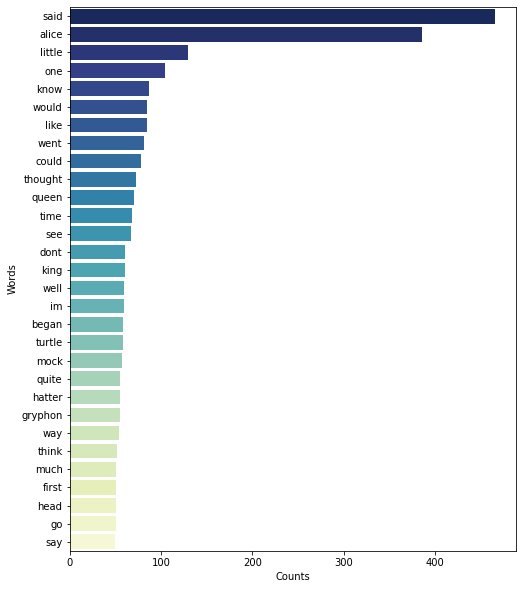

In [23]:
# Plot frequencies
words_plot_sw = pd.DataFrame(top_counts_sw, columns = ['Words', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Words", x="Counts", data=words_plot_sw, palette = "YlGnBu_r")

In [24]:
# Explore longer words, potentially as a signal for more "meaningful" words. Notice that some of these words
# were compound phrases and adjectives, such as "cucumberframe," which appears in the text as "cucumber-frame."
V = set(tokens)
long_words = [w for w in V if len(w) > 10]
print('Unique words over 10 characters:', len(long_words))
print('--------------------------------')
sorted(long_words)

['accidentally',
 'affectionately',
 'alternately',
 'antipathies',
 'backsomersault',
 'barleysugar',
 'beautifully',
 'bookshelves',
 'breadandbutter',
 'caterpillar',
 'caterpillars',
 'circumstances',
 'comfortable',
 'comfortably',
 'complaining',
 'considering',
 'consultation',
 'contemptuous',
 'contemptuously',
 'contradicted',
 'conversation',
 'conversations',
 'croquetground',
 'crossexamine',
 'cucumberframe',
 'cucumberframes',
 'desperately',
 'difficulties',
 'disappeared',
 'disappointment',
 'distraction',
 'drawlingmaster',
 'encouraging',
 'everythings',
 'exclamation',
 'executioner',
 'executioners',
 'explanation',
 'explanations',
 'extraordinary',
 'fishfootman',
 'frogfootman',
 'goodnatured',
 'goodnaturedly',
 'handwriting',
 'hippopotamus',
 'hottempered',
 'illustration',
 'immediately',
 'impatiently',
 'impertinent',
 'incessantly',
 'indignantly',
 'inquisitively',
 'interesting',
 'interrupted',
 'interrupting',
 'jackinthebox',
 'lessonbooks',
 'looki

In [25]:
# Bigram analysis
bigram_list = list(nltk.bigrams(tokens))

# Display number of total bigrams and number of unique bigrams
print('Total bigrams across text: ' + str(len(bigram_list)))
print('Unique bigrams across text: ' + str(len(set(bigram_list))))

Total bigrams across text: 26716
Unique bigrams across text: 14720


In [0]:
# Plot word frequency
# Initialize a dictionary
dict_bigrams = {}

# Count number of times each word comes up in list of words
for key in bigram_list: 
    dict_bigrams[key] = dict_bigrams.get(key, 0) + 1

counts_bigrams = sorted(dict_bigrams.items(), key = lambda x: x[1], reverse = True)

In [0]:
# Most and least frequent word occurence
top_counts_bigrams = counts_bigrams[:30]
least_counts_bigrams = counts_bigrams[-30:]

In [28]:
print('top occuring bigrams:', top_counts_bigrams)
print('--------------------------')
print('least occuring bigrams:', least_counts_bigrams)

top occuring bigrams: [(('said', 'the'), 210), (('of', 'the'), 130), (('said', 'alice'), 116), (('in', 'a'), 97), (('and', 'the'), 83), (('in', 'the'), 78), (('it', 'was'), 75), (('to', 'the'), 73), (('the', 'queen'), 68), (('she', 'had'), 61), (('as', 'she'), 61), (('a', 'little'), 61), (('the', 'king'), 60), (('at', 'the'), 57), (('she', 'was'), 55), (('mock', 'turtle'), 55), (('the', 'mock'), 54), (('to', 'be'), 53), (('and', 'she'), 53), (('the', 'gryphon'), 53), (('the', 'hatter'), 51), (('went', 'on'), 47), (('to', 'herself'), 46), (('you', 'know'), 45), (('said', 'to'), 40), (('the', 'duchess'), 39), (('out', 'of'), 37), (('there', 'was'), 36), (('that', 'she'), 36), (('with', 'the'), 36)]
--------------------------
least occuring bigrams: [(('and', 'eager'), 1), (('eager', 'with'), 1), (('with', 'many'), 1), (('many', 'a'), 1), (('a', 'strange'), 1), (('strange', 'tale'), 1), (('tale', 'perhaps'), 1), (('perhaps', 'even'), 1), (('even', 'with'), 1), (('the', 'dream'), 1), (('dr

**Figure 3: 30 most frequently occurring bi-grams in text**

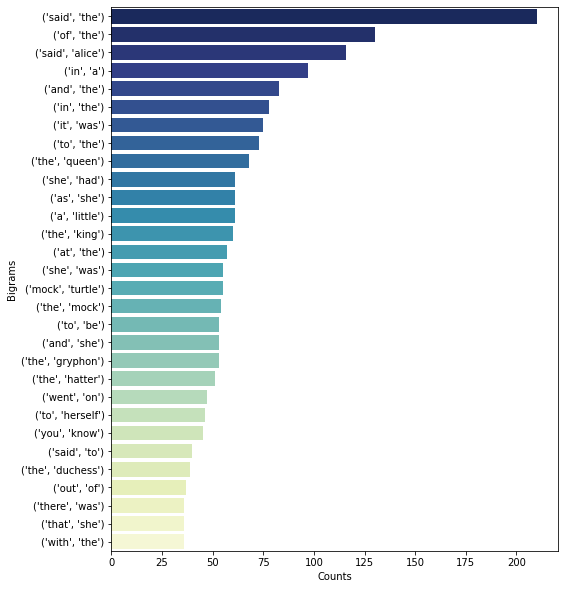

In [29]:
# Plot frequencies
bigrams_plot = pd.DataFrame(top_counts_bigrams, columns = ['Bigrams', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Bigrams", x="Counts", data=bigrams_plot, palette = "YlGnBu_r")

In [0]:
# # Find most frequently occurring bigrams (top 30)
# counter=Counter(bigram_list)
# # print(counter.most_common(30))
# print('Most common bigrams: ' + '\n' + str(counter.most_common(30)))

## 3. Save clean text as sequences and load document into memory
Sequence length is a key design decision: they must be long enough to properly allow models to learn the context and make reasonable predictions. The sequence length also defines the seed text length used to generate text sequences for model evaluation. A length of 50 is selected for this study, with sequences serving as inputs and training patterns to the various models. 

In [31]:
# Organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # Select sequence of tokens
    seq = tokens[i-length:i]
    # Convert into a line
    line = ' '.join(seq)
    # Store
    sequences.append(line)
print('Total sequences: %d' % len(sequences))

Total sequences: 26666


In [0]:
# Save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [0]:
# Save sequences to file
out_filename = 'alice_sequences.txt'
save_doc(sequences, out_filename)

In [0]:
# Define function to load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [0]:
# Load doc
in_filename = 'alice_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

## 4. Prepare data sequences for neural network input

The Tokenizer class in Keras is used to encode input sequences to integers, which the neural networks expect as input. The vocabulary size, defined by this encoding process, is defined as the vocabulary + 1 in length for feeding to the Embedding layer. After encoding, sequences are separated into input (X) and output (y) elements using array slicing. Output words are one hot encoded so the models in the study can predict the probability distribution for the next word.

In [0]:
# Integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [0]:
# Define vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [38]:
vocab_size

2646

In [0]:
# Separate sequences into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [40]:
print('Total Sequences: %d' % len(sequences))

Total Sequences: 26666


## 5. Train language models

To train statistical models from the data, these experiments all employ an embedding layer to learn the representation of words. Parameterization of words as vectors in this manner, learned as part of the training process, enables words with a similar meaning to have a similar representation. LSTM RNNs then learn to predict words based on context. There is no test dataset: models are trained on the entire training dataset to learn the probability of each word in a sequence.

All models will employ the following hyperparameters for consistency and evaluation purposes:
* Loss function: categorical cross-entropy
* Optimizer: adam
* Batch size: 128
* Training epochs: 50
* Early stopping with patience of 5

### <i>Baseline experiment 1: LSTM RNN</i> 
This first neural network serves as a baseline, with a simple architecture and fewer memory cell units, to evaluate model performance on this text with a relatively spare neural network.
* 1 hidden layer
* 100 memory cell units
* Embedding vector space size 50

In [0]:
# Define model
model_1 = Sequential()
model_1.add(Embedding(vocab_size, 50, input_length=seq_length))
model_1.add(LSTM(100))
# model_1.add(LSTM(100))
model_1.add(Dense(100, activation='relu'))
model_1.add(Dense(vocab_size, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            132300    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 2646)              267246    
Total params: 470,046
Trainable params: 470,046
Non-trainable params: 0
_________________________________________________________________


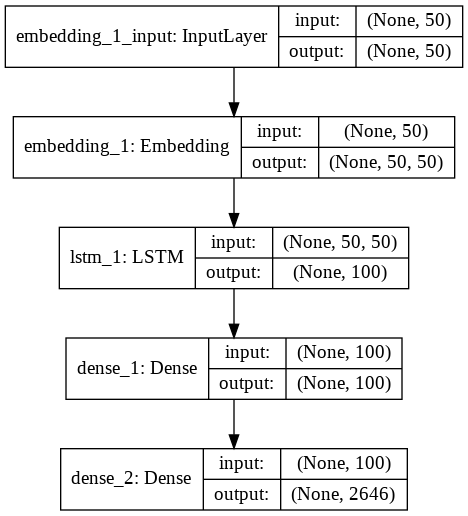

In [42]:
# Model summary
model_1.summary()
plot_model(model_1, to_file='figures/model_1.png', show_shapes=True)

In [0]:
# Compile model
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Define the checkpoint
# filepath='results/exp1/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5'
filepath='results/exp1/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [45]:
# Fit the model
start_time = time.time()
history = model_1.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
26666/26666 [==============================] - 31s 1ms/step - loss: 6.3278 - accuracy: 0.0564

Epoch 00001: loss improved from inf to 6.32783, saving model to results/exp1/best_model.hdf5
Epoch 2/50
26666/26666 [==============================] - 29s 1ms/step - loss: 5.9107 - accuracy: 0.0624

Epoch 00002: loss improved from 6.32783 to 5.91066, saving model to results/exp1/best_model.hdf5
Epoch 3/50
26666/26666 [==============================] - 30s 1ms/step - loss: 5.7379 - accuracy: 0.0659

Epoch 00003: loss improved from 5.91066 to 5.73790, saving model to results/exp1/best_model.hdf5
Epoch 4/50
26666/26666 [==============================] - 29s 1ms/step - loss: 5.5910 - accuracy: 0.0740

Epoch 00004: loss improved from 5.73790 to 5.59101, saving model to results/exp1/best_model.hdf5
Epoch 5/50
26666/26666 [==============================] - 29s 1ms/step - loss: 5.4520 - accuracy: 0.0828

Epoch 00005: loss improved from 5.59101 to 5.45196, saving model to results/exp1/best_

In [0]:
# Plot model performance

In [0]:
# history_dict = history.history
# history_dict.keys()

**Figure 4: Learning curves for Model 1**

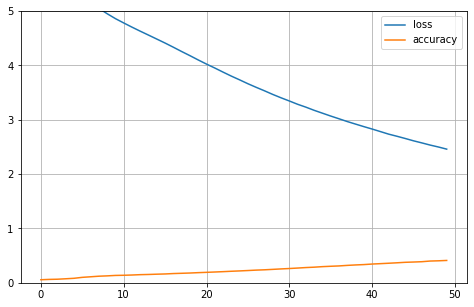

In [46]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5) # set the vertical range to [0-5]
plt.savefig('figures/learning_curves_model_1', tight_layout=False)
plt.show()

In [0]:
# Save the model to file
model_1.save('results/exp1/model_1.h5')
# Save the tokenizer
dump(tokenizer, open('alice_tokenizer.pkl', 'wb'))

In [0]:
# Prepare the language model

In [0]:
# Load cleaned text sequences
in_filename = 'alice_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [50]:
# Load the model
model = load_model('results/exp1/model_1.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# Load the tokenizer
tokenizer = load(open('alice_tokenizer.pkl', 'rb'))

In [0]:
# Generate text and evaluate

In [0]:
# Define function to generate sequence from language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [0]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [54]:
# Generate new text
print('Seed text 1:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

Seed text 1: hurry an enormous puppy was looking down at her with large round eyes and feebly stretching out one paw trying to touch her poor little thing said alice in a coaxing tone and she tried hard to whistle to it but she was terribly frightened all the time at the thought
----------------------------------
Generated text 1: to the jury they all a little quicker that your majesty said the king and then it was a little startled by seeing the world lets try the king when the march hare meekly is you might like the mock turtle said the mock turtle to her age give him


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [56]:
# Generate new text
print('Seed text 2:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

Seed text 2: down would the fall never come to an end i wonder how many miles ive fallen by this time she said aloud i must be getting somewhere near the centre of the earth let me see that would be four thousand miles down i think for you see alice had learnt
----------------------------------
Generated text 2: several times six minute and then you know pointing to the little door and was suppressed to the other side the queen was so much already as it was a little startled improve his shining tail and pour the waters of the nile on which instantly and the other side


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [58]:
# Generate new text
print('Seed text 3:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

Seed text 3: burn the house down said the rabbits voice and alice called out as loud as she could if you do ill set dinah at you there was a dead silence instantly and alice thought to herself i wonder what they will do next if they had any sense theyd take the
----------------------------------
Generated text 3: same size to the jury all wrote down their slates and was a little startled when she heard a little pattering of feet as it was a little nervous about it and feebly stretching out straight anxiously into the pool the queen was thatched with fur the frogfootman repeated with


In [0]:
tf.keras.backend.clear_session()

### <i>Experiment 2: LSTM RNN </i>
This neural network differs from the baseline with additional memory cell units.
* 1 hidden layer
* 256 memory cell units
* Embedding vector space size 50

In [0]:
# Define model
model_2 = Sequential()
model_2.add(Embedding(vocab_size, 50, input_length=seq_length))
model_2.add(LSTM(256))
model_2.add(Dense(100, activation='relu'))
model_2.add(Dense(vocab_size, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            132300    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_2 (Dense)              (None, 2646)              267246    
Total params: 739,614
Trainable params: 739,614
Non-trainable params: 0
_________________________________________________________________


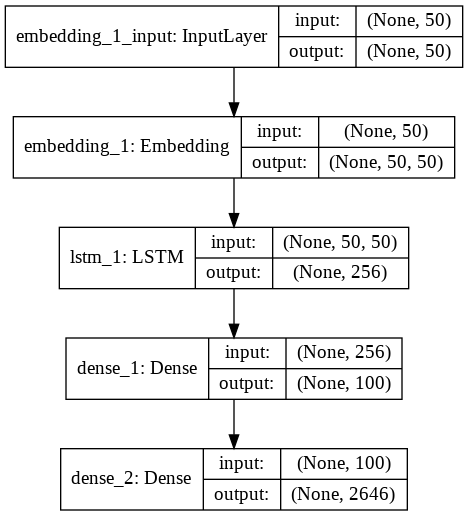

In [61]:
# Model summary
model_2.summary()
plot_model(model_2, to_file='figures/model_2.png', show_shapes=True)

In [0]:
# Compile model
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Define the checkpoint
# filepath='results/exp2/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5'
filepath='results/exp2/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint,es]

In [64]:
# Fit the model
start_time = time.time()
history = model_2.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
26666/26666 [==============================] - 32s 1ms/step - loss: 6.2853 - accuracy: 0.0609

Epoch 00001: loss improved from inf to 6.28529, saving model to results/exp2/best_model.hdf5
Epoch 2/50
26666/26666 [==============================] - 32s 1ms/step - loss: 5.8896 - accuracy: 0.0646

Epoch 00002: loss improved from 6.28529 to 5.88962, saving model to results/exp2/best_model.hdf5
Epoch 3/50
26666/26666 [==============================] - 31s 1ms/step - loss: 5.6907 - accuracy: 0.0714

Epoch 00003: loss improved from 5.88962 to 5.69068, saving model to results/exp2/best_model.hdf5
Epoch 4/50
26666/26666 [==============================] - 31s 1ms/step - loss: 5.5605 - accuracy: 0.0779

Epoch 00004: loss improved from 5.69068 to 5.56048, saving model to results/exp2/best_model.hdf5
Epoch 5/50
26666/26666 [==============================] - 32s 1ms/step - loss: 5.4123 - accuracy: 0.0877

Epoch 00005: loss improved from 5.56048 to 5.41232, saving model to results/exp2/best_

In [0]:
# Plot model performance

In [0]:
# history_dict = history.history
# history_dict.keys()

**Figure 5: Learning curves for Model 2**

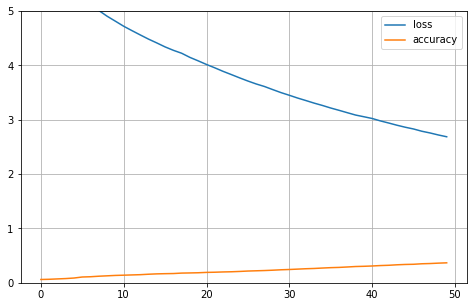

In [66]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5) # set the vertical range to [0-1]
plt.savefig('figures/learning_curves_model_2', tight_layout=False)
plt.show()

In [0]:
# Save the model to file
model_2.save('results/exp2/model_2.h5')
# save the tokenizer
# dump(tokenizer, open('alice_tokenizer.pkl', 'wb'))

In [0]:
# Prepare the language model

In [0]:
# Load cleaned text sequences
in_filename = 'alice_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [69]:
# Load the model - use name from best model
model = load_model('results/exp2/model_2.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# Load the tokenizer
tokenizer = load(open('alice_tokenizer.pkl', 'rb'))

In [0]:
# Generate text and evaluate

In [0]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [73]:
# Generate new text
print('Seed text 1:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

Seed text 1: change the subject ten hours the first day said the mock turtle nine the next and so on what a curious plan exclaimed alice thats the reason theyre called lessons the gryphon remarked because they lessen from day to day this was quite a new idea to alice and she thought
----------------------------------
Generated text 1: till it was very glad to be a bit hurt and went on when it grunted again and pictures hung upon pegs she waited to the cur a large cauldron among the door and she was the best butter a little girl shell think it to be true you know


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [75]:
# Generate new text
print('Seed text 2:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

Seed text 2: a good character but said i could not swim he sent them word i had not gone we know it to be true if she should push the matter on what would become of you i gave her one they gave him two you gave us three or more they all
----------------------------------
Generated text 2: returned from him and began to the queen of the court and the baby was too sulkily but she had never been to the classical master though the rabbit blew first filled with a low voice with the middle alice had just begun to the other side of the court


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [77]:
# Generate new text
print('Seed text 3:', seed_text)
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

Seed text 3: began to cry again for she felt very lonely and lowspirited in a little while however she again heard a little pattering of footsteps in the distance and she looked up eagerly half hoping that the mouse had changed his mind and was coming back to finish his story chapter iv
----------------------------------
Generated text 3: sidenote the door and knocked you cant help it said the king and the moral of the e e evening beautiful soup soup said to the gryphon and the moral of the court and a partner to be a bit hurt and went on when it grunted again and pictures


In [0]:
tf.keras.backend.clear_session()

### <i>Experiment 3: LSTM RNN </i>
This deeper neural network adds a hidden layer to determine impact on performance, training time, and ability to capture context of the document and generate meaningful text from seed text.
* 2 hidden layers
* 100 memory cell units
* Embedding vector space size 50

In [0]:
# Define model
model_3 = Sequential()
model_3.add(Embedding(vocab_size, 50, input_length=seq_length))
model_3.add(LSTM(100, return_sequences=True))
model_3.add(LSTM(100))
model_3.add(Dense(100, activation='relu'))
model_3.add(Dense(vocab_size, activation='softmax'))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            132300    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 2646)              267246    
Total params: 550,446
Trainable params: 550,446
Non-trainable params: 0
_________________________________________________________________


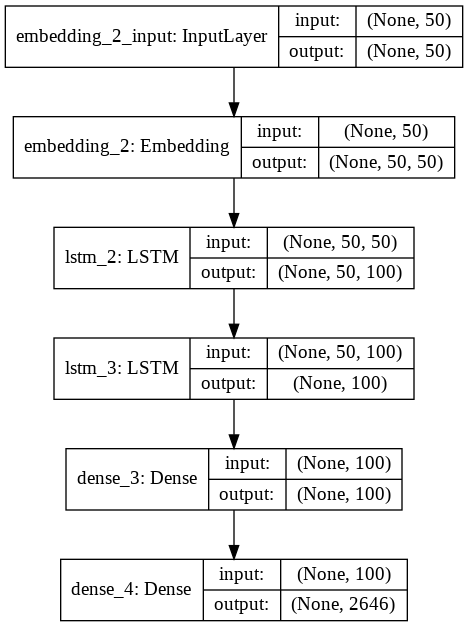

In [79]:
# Model summary
model_3.summary()
plot_model(model_3, to_file='figures/model_3.png', show_shapes=True)

In [0]:
# Compile model
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Define the checkpoint
filepath='results/exp3/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [82]:
# Fit the model
start_time = time.time()
history = model_3.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
26666/26666 [==============================] - 56s 2ms/step - loss: 6.3449 - accuracy: 0.0585

Epoch 00001: loss improved from inf to 6.34490, saving model to results/exp3/best_model.hdf5
Epoch 2/50
26666/26666 [==============================] - 55s 2ms/step - loss: 5.9796 - accuracy: 0.0615

Epoch 00002: loss improved from 6.34490 to 5.97957, saving model to results/exp3/best_model.hdf5
Epoch 3/50
26666/26666 [==============================] - 55s 2ms/step - loss: 5.8124 - accuracy: 0.0647

Epoch 00003: loss improved from 5.97957 to 5.81244, saving model to results/exp3/best_model.hdf5
Epoch 4/50
26666/26666 [==============================] - 54s 2ms/step - loss: 5.6570 - accuracy: 0.0732

Epoch 00004: loss improved from 5.81244 to 5.65704, saving model to results/exp3/best_model.hdf5
Epoch 5/50
26666/26666 [==============================] - 54s 2ms/step - loss: 5.5328 - accuracy: 0.0767

Epoch 00005: loss improved from 5.65704 to 5.53276, saving model to results/exp3/best_

In [0]:
 # Plot model performance

In [0]:
# history_dict = history.history
# history_dict.keys()

**Figure 6: Learning curves for Model 3**

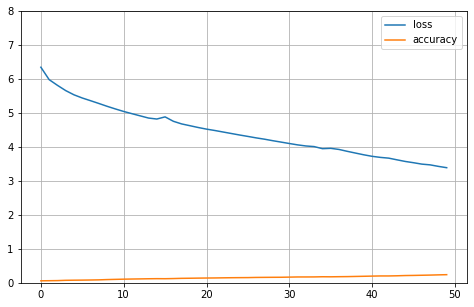

In [85]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 8) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3", tight_layout=False)
plt.show()

In [0]:
# Save the model to file
model_3.save('results/exp3/model_3.h5')
# save the tokenizer
# dump(tokenizer, open('alice_tokenizer.pkl', 'wb'))

In [0]:
# Prepare the language model

In [0]:
# Load cleaned text sequences
in_filename = 'alice_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [88]:
# Load the model - use name from best model
model = load_model('results/exp3/model_3.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# Load the tokenizer
tokenizer = load(open('alice_tokenizer.pkl', 'rb'))

In [0]:
# Generate text and evaluate

In [0]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [93]:
# Generate new text
print('Seed text 1:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

Seed text 1: used to say when i was a child said the gryphon well i never heard it before said the mock turtle but it sounds uncommon nonsense alice said nothing she had sat down with her face in her hands wondering if anything would ever happen in a natural way again i

----------------------------------
Generated text 1: should think it was a little startled she carried it a little startled she carried it a little startled she carried it to itself it as she had been to be out of sight and the flame of the pool and the march hare interrupted in a minute tone two


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [95]:
# Generate new text
print('Seed text 2:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

Seed text 2: say anything about it even if i fell off the top of the house which was very likely true down down down would the fall never come to an end i wonder how many miles ive fallen by this time she said aloud i must be getting somewhere near the centre

----------------------------------
Generated text 2: of the door and the march hare she was form and then she had been to be out to the window and the march hare interrupted yawning and the gryphon was the queen was in the middle of the distance and the march hare interrupted yawning and looked down and


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [97]:
# Generate new text
print('Seed text 3:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

Seed text 3: voice thats bill thought alice well i hardly know no more thank ye im better now but im a deal too flustered to tell you all i know is something comes at me like a jackinthebox and up i goes like a skyrocket so you did old fellow said the others

----------------------------------
Generated text 3: and the hatter was the queen was in a smile she was a little startled she carried it a little turnup were howling than it was the same shedding gallons of tears and then she had been to be otherwise than that she was a little turnup were of the


In [0]:
tf.keras.backend.clear_session()

### <i>Experiment 4: LSTM RNN with 2 hidden layers and additional memory cell units</i>
This deeper neural network adds memory cell units to the architecture of the model from Experiment 3 to determine impact on performance, training time, and ability to capture context of the document and generate meaningful text from seed text.
* 2 hidden layers
* 256 memory cell units
* Embedding vector space size 50

In [0]:
# Define model
model_4 = Sequential()
model_4.add(Embedding(vocab_size, 50, input_length=seq_length))
model_4.add(LSTM(256, return_sequences=True))
model_4.add(LSTM(256))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dense(vocab_size, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            132300    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 256)           314368    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 2646)              680022    
Total params: 1,717,794
Trainable params: 1,717,794
Non-trainable params: 0
_________________________________________________________________


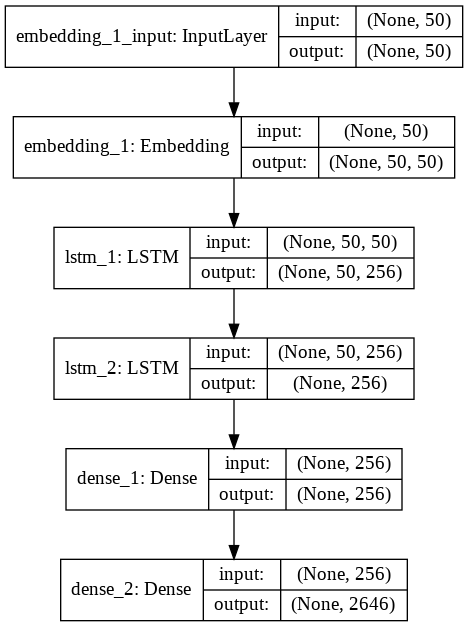

In [100]:
# Model summary
model_4.summary()
plot_model(model_4, to_file='figures/model_4.png', show_shapes=True)

In [0]:
# Compile model
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Define the checkpoint
filepath='results/exp4/est_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [103]:
# Fit the model
start_time = time.time()
history = model_4.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
26666/26666 [==============================] - 61s 2ms/step - loss: 6.2938 - accuracy: 0.0591

Epoch 00001: loss improved from inf to 6.29379, saving model to results/exp4/est_model.hdf5
Epoch 2/50
26666/26666 [==============================] - 60s 2ms/step - loss: 5.9340 - accuracy: 0.0625

Epoch 00002: loss improved from 6.29379 to 5.93400, saving model to results/exp4/est_model.hdf5
Epoch 3/50
26666/26666 [==============================] - 60s 2ms/step - loss: 5.7089 - accuracy: 0.0714

Epoch 00003: loss improved from 5.93400 to 5.70886, saving model to results/exp4/est_model.hdf5
Epoch 4/50
26666/26666 [==============================] - 60s 2ms/step - loss: 5.5231 - accuracy: 0.0771

Epoch 00004: loss improved from 5.70886 to 5.52310, saving model to results/exp4/est_model.hdf5
Epoch 5/50
26666/26666 [==============================] - 60s 2ms/step - loss: 5.4023 - accuracy: 0.0807

Epoch 00005: loss improved from 5.52310 to 5.40227, saving model to results/exp4/est_model

In [0]:
# Plot model performance

In [0]:
# history_dict = history.history
# history_dict.keys()

**Figure 7: Learning curves for Model 4**

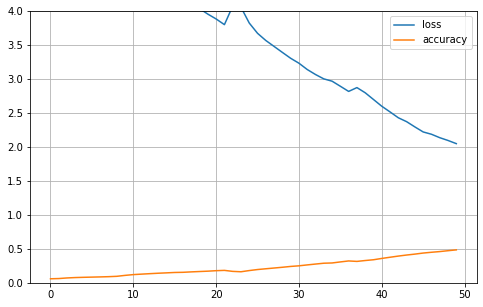

In [104]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4) # set the vertical range to [0-1]
plt.savefig('figures/learning_curves_model_4', tight_layout=False)
plt.show()

In [0]:
# Save the model to file
model_4.save('results/exp4/model_4.h5')
# save the tokenizer
# dump(tokenizer, open('alice_tokenizer.pkl', 'wb'))

In [0]:
# Prepare the language model

In [0]:
# Load cleaned text sequences
in_filename = 'alice_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [107]:
# Load the model - use name from best model
model = load_model('results/exp4/model_4.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# Load the tokenizer
tokenizer = load(open('alice_tokenizer.pkl', 'rb'))

In [0]:
# Generate text and evaluate

In [0]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [110]:
# Generate new text
print('Seed text 1:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

Seed text 1: going to begin again it was very provoking to find that the hedgehog had unrolled itself and was in the act of crawling away besides all this there was generally a ridge or a furrow in the way wherever she wanted to send the hedgehog to and as the doubledup soldiers

----------------------------------
Generated text 1: were always getting up and walking off with william the queen and the march hare said in a great hurry that was linked up into the sky in a low trembling voice than she set to work shaking him and ourselves and she did not venture to have finished the


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [112]:
# Generate new text
print('Seed text 2:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

Seed text 2: him you by the hedge then silence and then another confusion of voices hold up his head brandy now dont choke him how was it old fellow what happened to you tell us all about it at last came a little feeble squeaking voice thats bill thought alice well i hardly

----------------------------------
Generated text 2: know how to herself what she looked up at once in a graceful air and was going back in a natural way at the top of the march hare she were all locked of the morning the shriek of the gryphon the squeaking of the lizards slatepencil and the choking


In [0]:
# Select a new seed text
seed_text = lines[randint(0,len(lines))]

In [114]:
# Generate new text
print('Seed text 3:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

Seed text 3: crown over the wig he did not look at all comfortable and it was certainly not becoming and thats the jurybox thought alice and those twelve creatures she was obliged to say creatures you see because some of them were animals and some were birds i suppose they are the jurors

----------------------------------
Generated text 3: said to the knave fetch me about the fire in the middle nursing the bill thought the king was the queen said to the jury who instantly not get up and leave back to the other side of the suppressed guineapigs filled the gryphon mixed up and bawled out into


In [0]:
tf.keras.backend.clear_session()

### <i>Experiment 5: LSTM RNN with larger embedding vector space</i>
This experiment takes the best model from Experiment 4, with 2 hidden layers and 256 memory cell units, and tests the increased embedding vector space on performance and interpretability.
* 2 hidden layers
* 100 memory cell units
* Embedding vector space size 100

In [0]:
# Define model
model_5 = Sequential()
model_5.add(Embedding(vocab_size, 100, input_length=seq_length))
model_5.add(LSTM(256))
model_5.add(Dense(256, activation='relu'))
model_5.add(Dense(vocab_size, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           264600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 2646)              680022    
Total params: 1,375,982
Trainable params: 1,375,982
Non-trainable params: 0
_________________________________________________________________


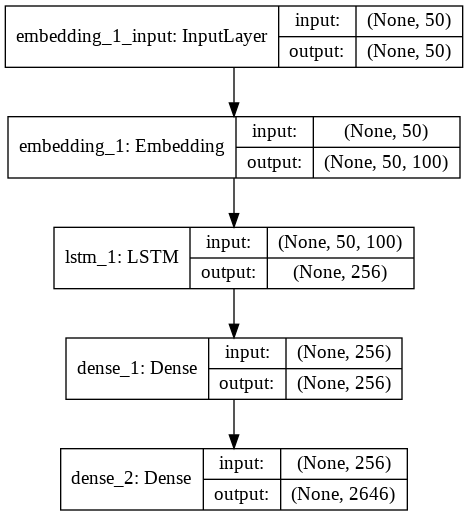

In [117]:
# Model summary
model_5.summary()
plot_model(model_5, to_file='figures/model_5.png', show_shapes=True)

In [0]:
# Compile model
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Define the checkpoint
filepath='results/exp5/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
callbacks_list = [checkpoint, es]

In [120]:
# Fit the model
start_time = time.time()
history = model_5.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
26666/26666 [==============================] - 33s 1ms/step - loss: 6.2583 - accuracy: 0.0579

Epoch 00001: loss improved from inf to 6.25835, saving model to results/exp5/best_model.hdf5
Epoch 2/50
26666/26666 [==============================] - 32s 1ms/step - loss: 5.8440 - accuracy: 0.0655

Epoch 00002: loss improved from 6.25835 to 5.84398, saving model to results/exp5/best_model.hdf5
Epoch 3/50
26666/26666 [==============================] - 31s 1ms/step - loss: 5.6113 - accuracy: 0.0774

Epoch 00003: loss improved from 5.84398 to 5.61131, saving model to results/exp5/best_model.hdf5
Epoch 4/50
26666/26666 [==============================] - 33s 1ms/step - loss: 5.3583 - accuracy: 0.0974

Epoch 00004: loss improved from 5.61131 to 5.35834, saving model to results/exp5/best_model.hdf5
Epoch 5/50
26666/26666 [==============================] - 32s 1ms/step - loss: 5.1375 - accuracy: 0.1185

Epoch 00005: loss improved from 5.35834 to 5.13751, saving model to results/exp5/best_

In [0]:
# Plot model performance

In [0]:
# history_dict = history.history
# history_dict.keys()

**Figure 8: Learning curves for Model 5**

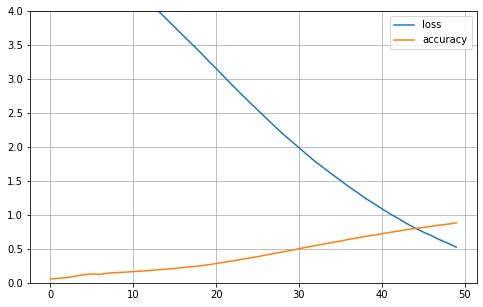

In [121]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 4) # set the vertical range to [0-1]
plt.savefig('figures/learning_curves_model_5', tight_layout=False)
plt.show()

In [0]:
# Save the model to file
model_5.save('results/exp5/model_5.h5')
# save the tokenizer
# dump(tokenizer, open('alice_tokenizer.pkl', 'wb'))

In [0]:
# Prepare the language model

In [0]:
# Load cleaned text sequences
in_filename = 'alice_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [124]:
# Load the model - use name from best model
model = load_model('results/exp5/model_5.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# Load the tokenizer
tokenizer = load(open('alice_tokenizer.pkl', 'rb'))

In [0]:
# Generate text and evaluate

In [0]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [127]:
# Generate new text
print('Seed text 1:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

Seed text 1: swam to the shore chapter iii sidenote a caucusrace and a long tale they were indeed a queerlooking party that assembled on the bank the birds with draggled feathers the animals with their fur clinging close to them and all dripping wet cross and uncomfortable the first question of course was

----------------------------------
Generated text 1: in the same age as herself to see if she could see this down no strange or to see what she were wanted to say said the dodo pointing to alice and sighing its the first day shell think it tells them being fast asleep after the while and was


In [0]:
# select a new seed text
seed_text = lines[randint(0,len(lines))]

In [129]:
# generate new text
print('Seed text 2:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

Seed text 2: begin again it was very provoking to find that the hedgehog had unrolled itself and was in the act of crawling away besides all this there was generally a ridge or a furrow in the way wherever she wanted to send the hedgehog to and as the doubledup soldiers were always

----------------------------------
Generated text 2: getting up and walking away without speaking but it was the jurors were writing on his cup of the ground as she added it isnt a little door and she did her to begin with it were beautifully else to make off the time my dear paws oh my fur


In [0]:
# select a new seed text
seed_text = lines[randint(0,len(lines))]

In [131]:
# generate new text
print('Seed text 3:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

Seed text 3: comes to at this moment five who had been anxiously looking across the garden called out the queen the queen and the three gardeners instantly threw themselves flat upon their faces there was a sound of many footsteps and alice looked round eager to see the queen first came ten soldiers

----------------------------------
Generated text 3: carrying clubs these were all shaped like the three gardeners oblong and flat with their hands and feet at the corners next the ten courtiers these were ornamented all over with diamonds and walked two and two she stood looking round the court and she began to watch it again


In [0]:
tf.keras.backend.clear_session()

### <i>Experiment 6: Bidirectional LSTM with 1 HL and 50% dropout</i>
This final experiment employs a Bidirectional LSTM and 50 percent dropout to evaluate WHAT.
* 1 hidden layer
* 256 memory cell units
* Embedding vector space size 50

In [0]:
# Define model
model_6 = Sequential()
model_6.add(Embedding(vocab_size, 50, input_length=seq_length))
model_6.add(Bidirectional(LSTM(256)))
model_6.add(Dropout(0.5))
# model_6.add(LSTM(256))
# model_6.add(Dense(256, activation='relu'))
model_6.add(Dense(vocab_size, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            132300    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               628736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2646)              1357398   
Total params: 2,118,434
Trainable params: 2,118,434
Non-trainable params: 0
_________________________________________________________________


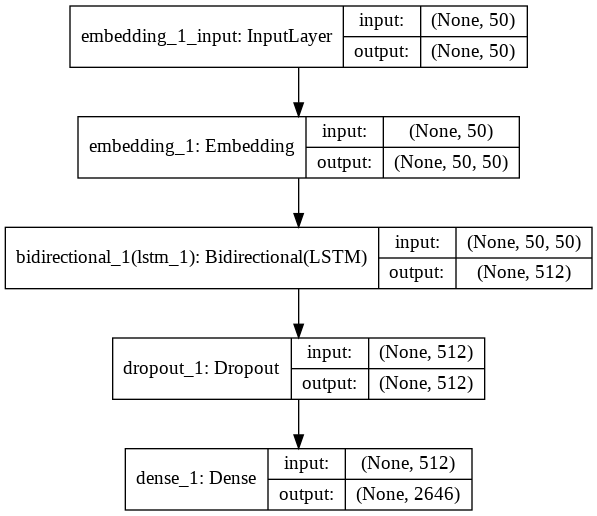

In [134]:
# Model summary
model_6.summary()
plot_model(model_6, to_file='figures/model_6.png', show_shapes=True)

In [0]:
# Compile model
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Define the checkpoint
filepath='results/exp6/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [137]:
# Fit the model
start_time = time.time()
history = model_6.fit(X, 
                      y, 
                      batch_size=128, 
                      epochs=50,
                      callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
26666/26666 [==============================] - 61s 2ms/step - loss: 6.3400 - accuracy: 0.0566

Epoch 00001: loss improved from inf to 6.34002, saving model to results/exp6/best_model.hdf5
Epoch 2/50
26666/26666 [==============================] - 59s 2ms/step - loss: 5.9931 - accuracy: 0.0623

Epoch 00002: loss improved from 6.34002 to 5.99306, saving model to results/exp6/best_model.hdf5
Epoch 3/50
26666/26666 [==============================] - 60s 2ms/step - loss: 5.8538 - accuracy: 0.0663

Epoch 00003: loss improved from 5.99306 to 5.85375, saving model to results/exp6/best_model.hdf5
Epoch 4/50
26666/26666 [==============================] - 61s 2ms/step - loss: 5.7213 - accuracy: 0.0729

Epoch 00004: loss improved from 5.85375 to 5.72133, saving model to results/exp6/best_model.hdf5
Epoch 5/50
26666/26666 [==============================] - 60s 2ms/step - loss: 5.6016 - accuracy: 0.0763

Epoch 00005: loss improved from 5.72133 to 5.60162, saving model to results/exp6/best_

In [0]:
# Plot model performance

In [0]:
# history_dict = history.history
# history_dict.keys()

**Figure 9: Learning curves for Model 6**

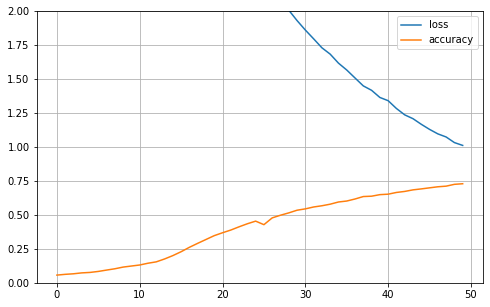

In [138]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.savefig('figures/learning_curves_model_6', tight_layout=False)
plt.show()

In [0]:
# Save the model to file
model_6.save('results/exp6/model_6.h5')
# save the tokenizer
# dump(tokenizer, open('alice_tokenizer.pkl', 'wb'))

In [0]:
# Prepare the language model

In [0]:
# Load cleaned text sequences
in_filename = 'alice_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Define sequence length
seq_length = len(lines[0].split()) - 1

In [142]:
# Load the model - use name from best model
model = load_model('results/exp6/model_6.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# Load the tokenizer
tokenizer = load(open('alice_tokenizer.pkl', 'rb'))

In [0]:
# Generate text and evaluate

In [0]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

In [146]:
# Generate new text
print('Seed text 1:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 1:', generated)

Seed text 1: knave was standing before them in chains with a soldier on each side to guard him and near the king was the white rabbit with a trumpet in one hand and a scroll of parchment in the other in the very middle of the court was a table with a large

----------------------------------
Generated text 1: dish of tarts upon it they looked so good that it made alice quite hungry to look at the house and the table was in the door of the door pray the refreshments was out of the other and alice was the court to the queens who were the queens


In [0]:
# select a new seed text
seed_text = lines[randint(0,len(lines))]

In [148]:
# generate new text
print('Seed text 2:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 2:', generated)

Seed text 2: she had to run back into the wood for fear of their hearing her and when she next peeped out the fishfootman was gone and the other was sitting on the ground near the door staring stupidly up into the sky alice went timidly up to the door and knocked theres

----------------------------------
Generated text 2: no use in knocking the queen was on for the executioner drink out of the distance and the next sidenote the royal soo oop of the evening beautiful soup of the e evening beautiful soup who chapter oop of the e e evening beautiful beautiful soup chapter soup of the


In [0]:
# select a new seed text
seed_text = lines[randint(0,len(lines))]

In [150]:
# generate new text
print('Seed text 3:', seed_text + '\n')
print('----------------------------------')
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print('Generated text 3:', generated)

Seed text 3: which was to twist it up into a knot and then keep tight hold of its right ear and left foot so as to prevent its undoing itself she carried it out into the open air if i dont take this child away with me thought alice theyre sure to kill

----------------------------------
Generated text 3: it in a day or two wouldnt be a murder of it and she said to herself it was out of the little thing and she was very like for it she had like her by this time she was a little bit however she thought to herself as she


In [0]:
tf.keras.backend.clear_session()